<a href="https://colab.research.google.com/github/bineee39/first-repository/blob/master/mini_project1208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(tfds.__version__)

2.19.0
4.9.9


In [ ]:
# 데이터셋 로드 및 분할
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # 80:10:10 분할
    with_info=True,
    as_supervised=True,
)

# 분류할 클래스 개수 확인 (총 5가지 꽃 종류)
NUM_CLASSES = metadata.features['label'].num_classes
print(f"데이터셋 로드 완료!")
print(f"총 클래스 개수: {NUM_CLASSES}")
print(f"훈련 데이터 개수: {tf.data.experimental.cardinality(raw_train).numpy()}")
print(f"검증 데이터 개수: {tf.data.experimental.cardinality(raw_validation).numpy()}")
print(f"테스트 데이터 개수: {tf.data.experimental.cardinality(raw_test).numpy()}")

In [4]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기
BATCH_SIZE = 32 # 한 번에 처리할 이미지 묶음 크기

def format_example(image, label):
    # 1. 이미지를 실수형으로 변환 (타입캐스팅)
    image = tf.cast(image, tf.float32)

    # 2. 픽셀 값 스케일링: 0~255 범위 -> -1~1 범위로 변환
    # (image / 127.5) 는 0~2 범위가 되고, 여기서 -1을 빼면 -1~1 범위가 됩니다.
    image = (image / 127.5) - 1

    # 3. 이미지 크기 통일
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("이미지 포맷팅 함수 준비 완료!")

이미지 포맷팅 함수 준비 완료!


In [5]:
SHUFFLE_BUFFER_SIZE = 1000

# 훈련 데이터 준비: 포맷팅 -> 섞기 -> 배치로 묶기
train_batches = raw_train.map(format_example).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 검증 및 테스트 데이터 준비: 포맷팅 -> 배치로 묶기
validation_batches = raw_validation.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = raw_test.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(" 학습용 배치 데이터셋 준비 완료!")

 학습용 배치 데이터셋 준비 완료!


In [6]:
# VGG16 모델을 특징 추출기로 사용하기 위해 불러옵니다.
# weights='imagenet': ImageNet 데이터셋으로 학습된 가중치(지식)를 가져옵니다.
# include_top=False: 모델의 맨 위에 있는 최종 분류 층(Dense)은 제외합니다.
# input_shape: 우리가 준비한 이미지 크기(160x160x3)를 알려줍니다.
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3) # (160, 160, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

# 특징 추출 부분은 학습시키지 않도록 동결(freeze)합니다.
# 이미 VGG16이 똑똑하게 학습했으므로, 가중치를 고정시킵니다.
base_model.trainable = False

print("Base Model (VGG16 특징 추출기) 준비 완료!")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base Model (VGG16 특징 추출기) 준비 완료!


In [9]:
# train_batches에서 첫 번째 묶음(배치) 데이터를 가져옵니다.
# .take(1)로 한 묶음만 가져오고, .as_numpy_iterator()로 숫자로 변환합니다.
# next()를 사용해서 그 묶음의 이미지와 라벨을 각각 받습니다.
image_batch, label_batch = next(iter(train_batches))
# VGG16의 출력 형태를 확인합니다.
feature_batch = base_model(image_batch)

# 특징 맵을 1차원 벡터로 압축 (특징 요약)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# Dense Layer: 특징을 조합하여 더 복잡한 판단을 내리는 중간 층
dense_layer = tf.keras.layers.Dense(units=512, activation='relu')

# Prediction Layer: 최종 5가지 꽃 확률을 출력하는 층
# units=NUM_CLASSES (5가지 꽃 종류)로 설정해야 합니다.
prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')

# 최종 모델 조합: VGG16 -> 특징 압축 -> Dense -> 최종 분류
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

print(" 최종 모델 설계 완료!")
model.summary()

 최종 모델 설계 완료!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# 1. 학습률 정의
base_learning_rate = 0.0001

# 2. 모델에게 공부 계획서를 전달 (Compile)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print(" 모델 컴파일 완료! 이제 학습 준비가 되었습니다.")
EPOCHS = 5
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

✅ 모델 컴파일 완료! 이제 학습 준비가 되었습니다.
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 673s 7s/step - accuracy: 0.4172 - loss: 1.4808 - val_accuracy: 0.6785 - val_loss: 1.1613
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 659s 7s/step - accuracy: 0.6782 - loss: 1.1112 - val_accuracy: 0.7112 - val_loss: 0.9252
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 679s 7s/step - accuracy: 0.7295 - loss: 0.8932 - val_accuracy: 0.7466 - val_loss: 0.8020
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 644s 7s/step - accuracy: 0.7685 - loss: 0.7793 - val_accuracy: 0.7548 - val_loss: 0.7235
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 689s 7s/step - accuracy: 0.7702 - loss: 0.7169 - val_accuracy: 0.7466 - val_loss: 0.6754


In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

print("성적표 데이터 준비 완료!")

성적표 데이터 준비 완료!


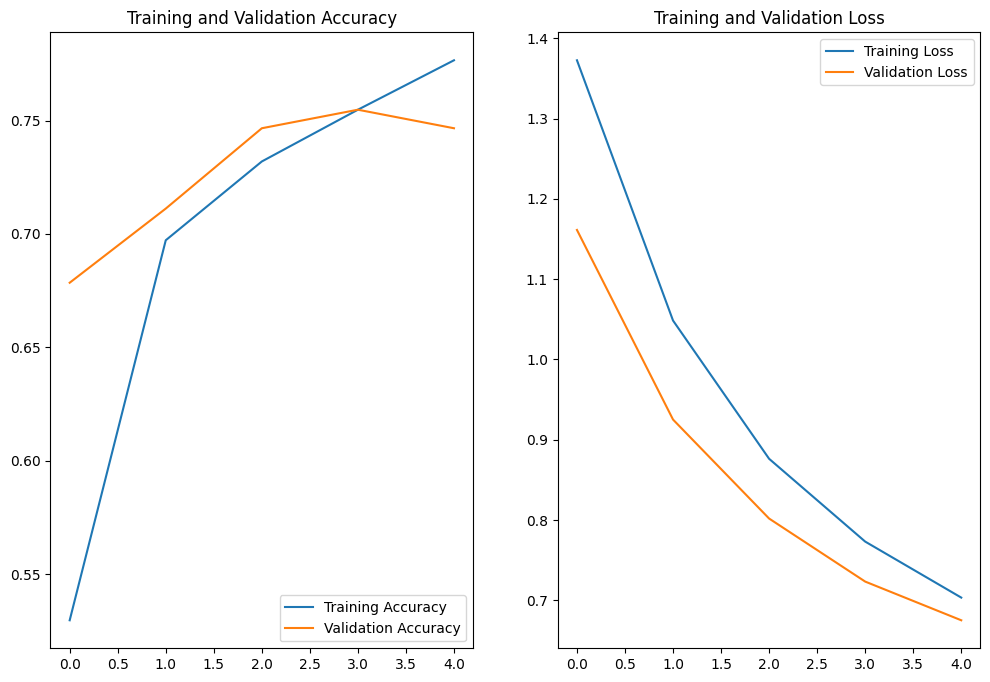

✅ 학습 과정 시각화 완료!


In [13]:
plt.figure(figsize=(12, 8))

# 1. 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# 2. 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("✅ 학습 과정 시각화 완료!")

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2),
], name="data_augmentation")

# 기존 base_model의 trainable 속성을 True로 설정하여 미세 조정을 준비합니다.
base_model.trainable = True

# 미세 조정을 위한 새 모델 구성
model_fine_tune = tf.keras.Sequential([
    data_augmentation, # 데이터 증강 레이어 추가
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), # 기존 global_average_layer 역할
    tf.keras.layers.Dense(units=512, activation='relu'), # 기존 dense_layer 역할
    tf.keras.layers.Dropout(0.5), # 과적합 방지를 위한 Dropout 레이어 추가
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax') # 최종 예측 레이어
], name="fine_tuned_model")

# 미세 조정을 위해 모델 컴파일 (Adam optimizer 사용, 낮은 학습률)
model_fine_tune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10), # 기존 학습률보다 더 낮게 설정
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("미세 조정을 위한 모델 재구성 및 컴파일 완료!")
model_fine_tune.summary()

미세 조정을 위한 모델 재구성 및 컴파일 완료!


Model: "fine_tuned_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
FINE_TUNE_EPOCHS = 5 # 미세 조정을 위한 에포크 수를 5로 줄입니다.

from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의
# val_loss가 3 에포크 동안 개선되지 않으면 학습을 중단합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print(f"FINE_TUNE_EPOCHS가 {FINE_TUNE_EPOCHS}로 설정되었습니다.")
print("EarlyStopping 콜백 준비 완료!")

FINE_TUNE_EPOCHS가 5로 설정되었습니다.
EarlyStopping 콜백 준비 완료!


In [17]:
history_fine_tune = model_fine_tune.fit(
    train_batches,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=validation_batches,
    callbacks=[early_stopping_callback]
)

print("미세 조정 학습 완료!")

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2179s 24s/step - accuracy: 0.7253 - loss: 0.7610 - val_accuracy: 0.8120 - val_loss: 0.5225
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2105s 23s/step - accuracy: 0.7812 - loss: 0.5868 - val_accuracy: 0.8338 - val_loss: 0.4969
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2075s 23s/step - accuracy: 0.8333 - loss: 0.4477 - val_accuracy: 0.8392 - val_loss: 0.4320
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2108s 23s/step - accuracy: 0.8386 - loss: 0.4385 - val_accuracy: 0.8474 - val_loss: 0.4378
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2121s 23s/step - accuracy: 0.8727 - loss: 0.3763 - val_accuracy: 0.8420 - val_loss: 0.4458
미세 조정 학습 완료!


**Reasoning**:
Now that the model has been fine-tuned, the next step is to evaluate its performance on the test dataset to assess its generalization capabilities.



In [18]:
loss, accuracy = model_fine_tune.evaluate(test_batches)
print(f"테스트 데이터 손실: {loss:.4f}")
print(f"테스트 데이터 정확도: {accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 72s 6s/step - accuracy: 0.8988 - loss: 0.3063
테스트 데이터 손실: 0.3141
테스트 데이터 정확도: 0.8992


**Reasoning**:
To visualize the performance of the fine-tuned model during training, I need to extract the accuracy and loss values for both training and validation sets from the `history_fine_tune` object.



In [19]:
acc_fine_tune = history_fine_tune.history['accuracy']
val_acc_fine_tune = history_fine_tune.history['val_accuracy']

loss_fine_tune = history_fine_tune.history['loss']
val_loss_fine_tune = history_fine_tune.history['val_loss']

epochs_range_fine_tune = range(FINE_TUNE_EPOCHS)

print("Fine-tuned model's training history data prepared for plotting!")

Fine-tuned model's training history data prepared for plotting!


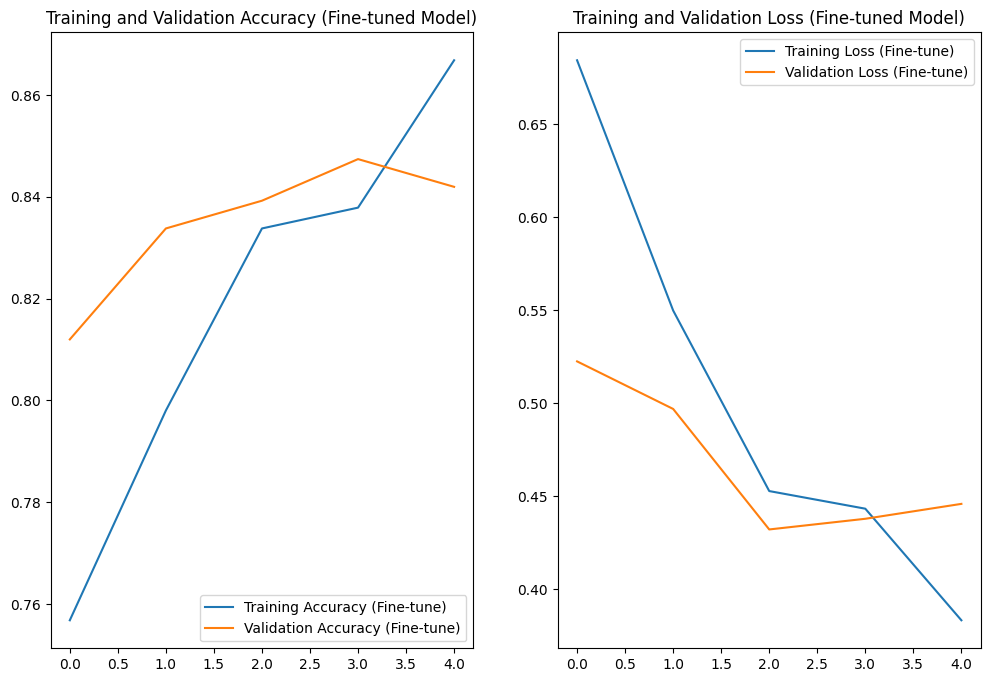

✅ Fine-tuned model training process visualized!


In [20]:
plt.figure(figsize=(12, 8))

# 1. Fine-tuned model accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range_fine_tune, acc_fine_tune, label='Training Accuracy (Fine-tune)')
plt.plot(epochs_range_fine_tune, val_acc_fine_tune, label='Validation Accuracy (Fine-tune)')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Fine-tuned Model)')

# 2. Fine-tuned model loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range_fine_tune, loss_fine_tune, label='Training Loss (Fine-tune)')
plt.plot(epochs_range_fine_tune, val_loss_fine_tune, label='Validation Loss (Fine-tune)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Fine-tuned Model)')
plt.show()

print("✅ Fine-tuned model training process visualized!")

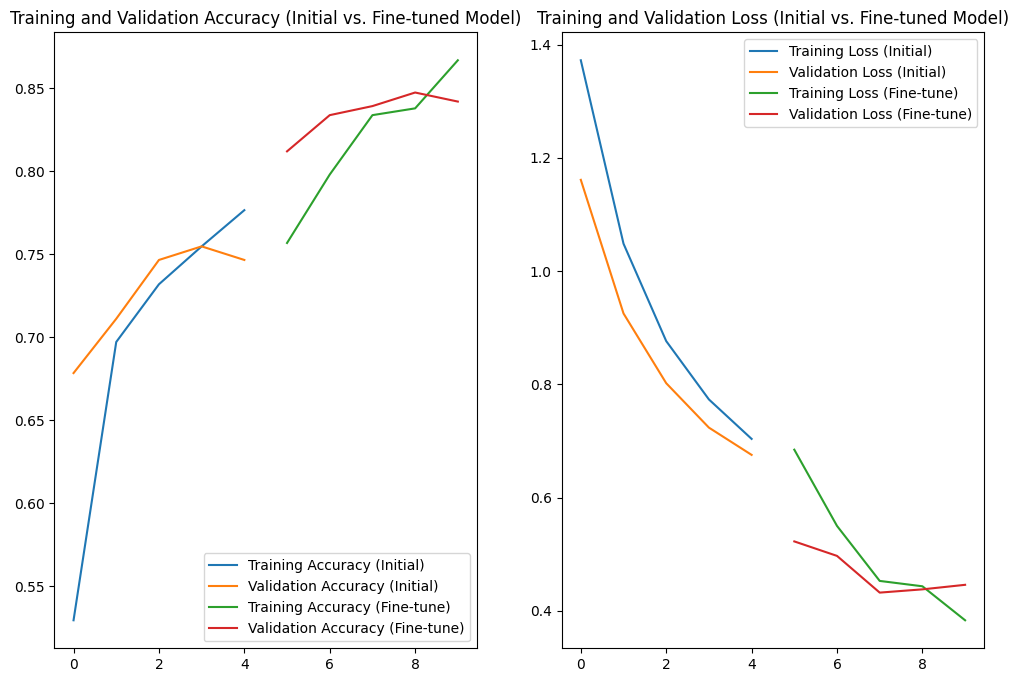

✅ Initial and Fine-tuned model training processes visualized for comparison!


In [22]:
import matplotlib.pyplot as plt

# Re-extract initial model's training history data to ensure correct lists are used
initial_acc = history.history['accuracy']
initial_val_acc = history.history['val_accuracy']
initial_loss = history.history['loss']
initial_val_loss = history.history['val_loss']

# Combine epoch ranges for plotting
total_epochs = EPOCHS + FINE_TUNE_EPOCHS
history_epochs = range(EPOCHS)
fine_tune_history_epochs = range(EPOCHS, total_epochs)

plt.figure(figsize=(12, 8))

# 1. Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history_epochs, initial_acc, label='Training Accuracy (Initial)')
plt.plot(history_epochs, initial_val_acc, label='Validation Accuracy (Initial)')
plt.plot(fine_tune_history_epochs, acc_fine_tune, label='Training Accuracy (Fine-tune)')
plt.plot(fine_tune_history_epochs, val_acc_fine_tune, label='Validation Accuracy (Fine-tune)')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Initial vs. Fine-tuned Model)')

# 2. Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history_epochs, initial_loss, label='Training Loss (Initial)')
plt.plot(history_epochs, initial_val_loss, label='Validation Loss (Initial)')
plt.plot(fine_tune_history_epochs, loss_fine_tune, label='Training Loss (Fine-tune)')
plt.plot(fine_tune_history_epochs, val_loss_fine_tune, label='Validation Loss (Fine-tune)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Initial vs. Fine-tuned Model)')
plt.show()

print("✅ Initial and Fine-tuned model training processes visualized for comparison!")

## 임의 이미지 예측 및 시각화

### Subtask:
테스트 데이터셋에서 몇 개의 이미지를 선택하여 모델이 예측한 결과(클래스 확률 및 최종 예측)와 실제 라벨을 함께 시각화하여 보여줍니다.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


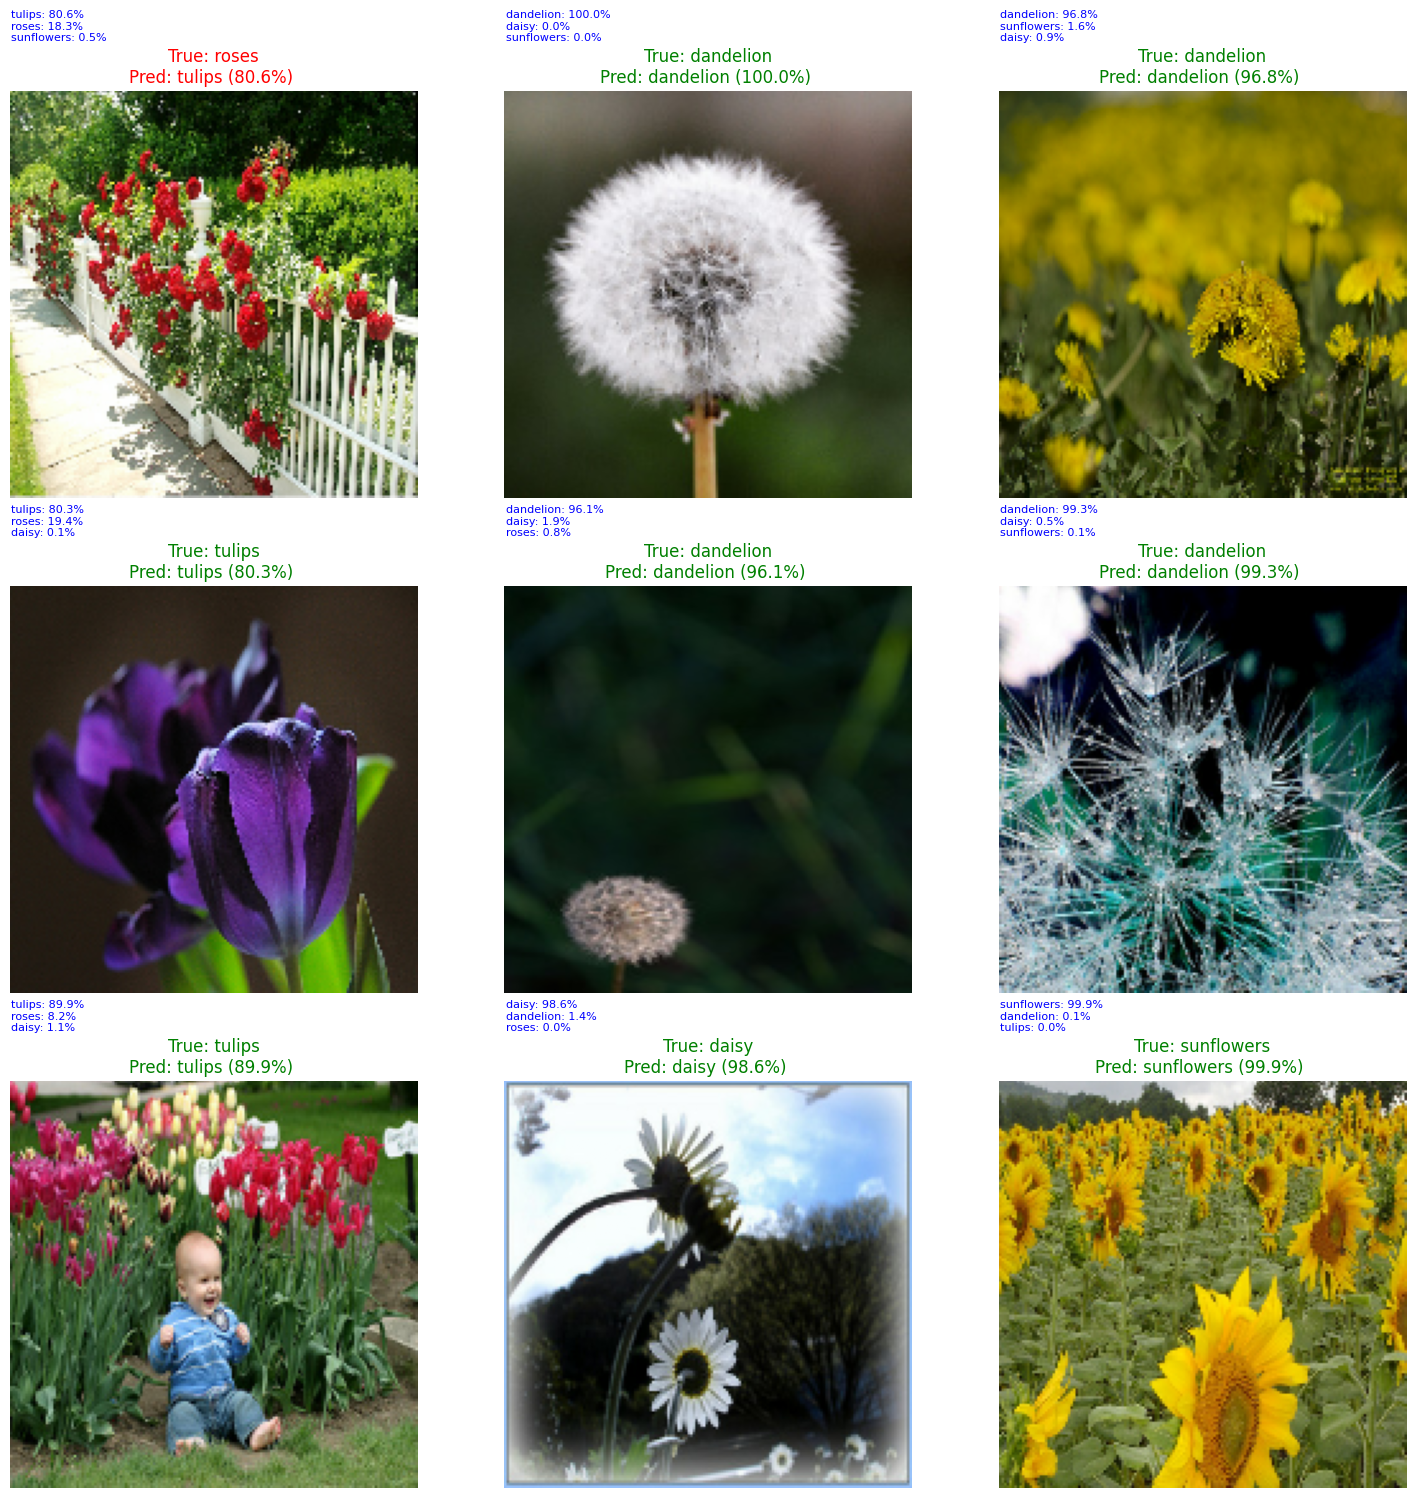

✅ 테스트 데이터셋 이미지 예측 및 시각화 완료!


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 테스트 데이터셋에서 이미지와 실제 라벨을 가져옵니다.
image_batch, label_batch = next(iter(test_batches))

# 2. metadata.features['label'].names를 사용하여 꽃 클래스 이름 목록을 class_names 변수에 저장합니다.
# metadata 변수는 이전 셀에서 tfds.load와 함께 로드되었습니다.
class_names = metadata.features['label'].names

# 3. model_fine_tune을 사용하여 image_batch에 대한 예측을 수행하고, 결과를 predictions 변수에 저장합니다.
predictions = model_fine_tune.predict(image_batch)

# 4. Matplotlib를 사용하여 3x3 격자의 그림을 생성합니다.
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # a. 이미지를 표시합니다.
    # 이미지는 -1~1 범위로 정규화되어 있으므로 0~1 범위로 다시 스케일링하여 표시합니다.
    plt.imshow((image_batch[i] + 1) / 2)

    true_label = label_batch[i].numpy()
    predicted_label = np.argmax(predictions[i])

    # b. 실제 라벨(True Label)과 예측 라벨(Predicted Label)을 제목으로 설정합니다.
    # 예측이 맞았으면 초록색으로, 틀렸으면 빨간색으로 표시합니다.
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]} ({predictions[i][predicted_label]*100:.1f}%) ", color=color)

    # c. 예측된 클래스 이름과 해당 확률을 텍스트로 추가하여 보여줍니다.
    # 여기서는 상위 3개 예측 확률을 보여주도록 하겠습니다.
    top_k_indices = predictions[i].argsort()[-3:][::-1] # 상위 3개 인덱스

    # 텍스트 오버랩 방지를 위해 이미지 상단에 표시
    text_str = ""
    for k in top_k_indices:
        text_str += f"{class_names[k]}: {predictions[i][k]*100:.1f}%\n"
    plt.text(0, -20, text_str.strip(), color='blue', fontsize=8)

    plt.axis('off')

# 6. plt.tight_layout()을 사용하여 서브플롯 간의 간격을 자동으로 조절하고, plt.show()로 그림을 표시합니다.
plt.tight_layout()
plt.show()

print("✅ 테스트 데이터셋 이미지 예측 및 시각화 완료!")